In [208]:
# import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gzip
import os
import glob
import re
from datetime import datetime

In [209]:
# get logs for month of February
folder_path = r'../../../lhstdata1/students/Gallica_logs/1LogGallicaFevrier2016'
all_files = glob.glob(folder_path + "/*.log.gz")
print(len(all_files))

2201


In [210]:
all_files.sort(key=lambda f: int(re.sub('\D', '', f)))

In [211]:
some_files = all_files[300:1000]

In [212]:
len(some_files)

700

In [213]:
# take only part of the data, to run tests on a smaller batch for speed, beginning of month
df = pd.read_csv(all_files[0], sep='\t', header=None)

In [350]:
pd.set_option('display.max_colwidth', None)  # Set column width to show entire content
first_row_str = df.iloc[0].to_string()

# Print the entire first row as a string
print(first_row_str)


0    ##e7fdec50f50253f6796d61b5382155f8##null##null##- - [31/Jan/2016:18:59:19 +0100] "GET /ark:/12148/bpt6k70211m HTTP/1.0" 200 24552 "-" "-" 48652


In [214]:
len(df)

114722

In [215]:
# split the lines to recover meaningful information
lines_df = df[0].str.split('##', expand=True)

In [216]:
lines_df.head()

,0,1,2,3,4
0,,e7fdec50f50253f6796d61b5382155f8,null,null,"- - [31/Jan/2016:18:59:19 +0100] ""GET /ark:/12..."
1,,5d1edaaaa9cf4772ce828127ce3e523a,United States,Chapel Hill,"- - [31/Jan/2016:18:59:20 +0100] ""GET /ark:/12..."
2,,fd91d2df98948719be32c40d684662fe,Mexico,Mexico City,"- - [31/Jan/2016:18:59:21 +0100] ""GET /service..."
3,,fd91d2df98948719be32c40d684662fe,Mexico,Mexico City,"- - [31/Jan/2016:18:59:21 +0100] ""GET /service..."
4,,fd91d2df98948719be32c40d684662fe,Mexico,Mexico City,"- - [31/Jan/2016:18:59:21 +0100] ""GET /service..."


In [217]:
#extracting dates
temp = pd.DataFrame()
temp['Date'] = lines_df.apply(lambda x: x[4].split("]")[0].split("[")[1], axis=1)

In [218]:
temp

,Date
0,31/Jan/2016:18:59:19 +0100
1,31/Jan/2016:18:59:20 +0100
2,31/Jan/2016:18:59:21 +0100
3,31/Jan/2016:18:59:21 +0100
4,31/Jan/2016:18:59:21 +0100
...,...
114717,01/Feb/2016:05:29:47 +0100
114718,01/Feb/2016:05:29:47 +0100
114719,01/Feb/2016:05:29:48 +0100
114720,01/Feb/2016:05:29:54 +0100


In [219]:
# extracting request
temp['Request'] = lines_df.apply(lambda x: ' '.join(x[4].split("\"")[1].split(' ')[:2]), axis=1)

In [220]:
# extracting referrer
temp['Referrer'] = lines_df.apply(lambda x: x[4].split("\"")[3], axis=1)

In [221]:
# find the percentage of unknown referrer, to decide if the feature is usable
nb_unknown_referrer = temp['Referrer'].value_counts()['-']
percentage_unknown_referrer = nb_unknown_referrer/len(temp) * 100
print("Percentage of unknown referrers : ", percentage_unknown_referrer)

Percentage of unknown referrers :  9.74529732745245


In [222]:
#extract request
temp['Request'] = lines_df.apply(lambda x: ' '.join(x[4].split("\"")[1].split(' ')[:2]), axis=1)

In [337]:
# function to extract ark from the request
def extract_ark(request):
    # init ark variable
    ark = '-'
    # regular expression pattern, 12148 is specific to gallica
    pattern = r'/12148/([^/.]+)'
    # use regec to find ark in request string
    match = re.search(pattern, request)
    if match:
        ark = match.group(1)
    return ark

# function to extract search term from request
def get_search_term(request): 
    # init search term
    search_terms = '-'
    
    if "search" in request:
        
        search_term_match = re.findall(r'gallica\s+adj\s+"([^"]+)"|subgallica\s+adj\s+"([^"]+)"', request)
    
        # If matches are found, extract the search terms
        if search_term_match:

            search_terms = [term for term in search_term_match[0] if term]  # Filter out empty matches
            
    return search_terms


temp['Ark'] = temp.apply(lambda x: extract_ark(x['Request']), axis=1)
temp['Search_term'] = temp.apply(lambda x: get_search_term(x['Request']), axis=1)

In [338]:
# rename the columns with informative names
lines_df = lines_df.rename(columns = {1:"IPaddress", 2:"Country", 3:"City", 4:"Full_request"})

In [339]:
final_df = pd.concat([lines_df, temp], axis=1)

In [342]:
final_df.loc[3]['Request']

'GET /services/engine/search/sru?operation=searchRetrieve&version=1.2&startRecord=0&maximumRecords=15&page=1&collapsing=disabled&query=arkPress%20all%20%22cb34348270x_date%22%20and%20dc.date%3D%221830%22%20and%20%28gallica%20adj%20%22Renduel%22%29'

In [343]:
final_df.loc[197]['Request']

'GET /services/engine/search/sru?operation=searchRetrieve&version=1.2&collapsing=disabled&query=arkPress%20all%20%22cb34348270x_date%22%20and%20dc.date%3D%221830%22%20and%20%28gallica%20adj%20%22Renduel%22%29%20and%20%28subgallica%20adj%20%22soir%C3%A9es%20de%20Walter%22%29'

In [341]:
final_df

,0,IPaddress,Country,City,Full_request,Date,Request,Referrer,Ark,Search_term
0,,e7fdec50f50253f6796d61b5382155f8,null,null,"- - [31/Jan/2016:18:59:19 +0100] ""GET /ark:/12...",31/Jan/2016:18:59:19 +0100,GET /ark:/12148/bpt6k70211m,-,bpt6k70211m,-
1,,5d1edaaaa9cf4772ce828127ce3e523a,United States,Chapel Hill,"- - [31/Jan/2016:18:59:20 +0100] ""GET /ark:/12...",31/Jan/2016:18:59:20 +0100,GET /ark:/12148/bpt6k622723.planchecontact.r=e...,-,bpt6k622723,-
2,,fd91d2df98948719be32c40d684662fe,Mexico,Mexico City,"- - [31/Jan/2016:18:59:21 +0100] ""GET /service...",31/Jan/2016:18:59:21 +0100,GET /services/ajax/extract/ark:/12148/bpt6k866...,http://gallica.bnf.fr/services/engine/search/s...,bpt6k866717,-
3,,fd91d2df98948719be32c40d684662fe,Mexico,Mexico City,"- - [31/Jan/2016:18:59:21 +0100] ""GET /service...",31/Jan/2016:18:59:21 +0100,GET /services/engine/search/sru?operation=sear...,http://gallica.bnf.fr/services/engine/search/s...,-,-
4,,fd91d2df98948719be32c40d684662fe,Mexico,Mexico City,"- - [31/Jan/2016:18:59:21 +0100] ""GET /service...",31/Jan/2016:18:59:21 +0100,GET /services/ajax/extract/ark:/12148/bpt6k653...,http://gallica.bnf.fr/services/engine/search/s...,bpt6k65309826,-
...,...,...,...,...,...,...,...,...,...,...
114717,,320022e99796ca35dab7e63d48fd5e7,null,null,"- - [01/Feb/2016:05:29:47 +0100] ""GET /ark:/12...",01/Feb/2016:05:29:47 +0100,GET /ark:/12148/bpt6k70211m,-,bpt6k70211m,-
114718,,dca9b098deeb6018c876f26db3272441,United States,Chicago,"- - [01/Feb/2016:05:29:47 +0100] ""GET //iiif/a...",01/Feb/2016:05:29:47 +0100,GET //iiif/ark:/12148/bpt6k6578408h/f38/full/2...,-,bpt6k6578408h,-
114719,,dca9b098deeb6018c876f26db3272441,United States,Chicago,"- - [01/Feb/2016:05:29:48 +0100] ""GET //iiif/a...",01/Feb/2016:05:29:48 +0100,GET //iiif/ark:/12148/bpt6k5482285k/f200/full/...,-,bpt6k5482285k,-
114720,,dca9b098deeb6018c876f26db3272441,United States,Chicago,"- - [01/Feb/2016:05:29:54 +0100] ""GET //iiif/a...",01/Feb/2016:05:29:54 +0100,GET //iiif/ark:/12148/bpt6k33526c/f227/full/17...,-,bpt6k33526c,-


In [257]:
# get percentage of unknown countries, to decide if column is usable
nb_unknown_countries = final_df['Country'].value_counts()['null']
percentage_unknown_countries = nb_unknown_countries/len(final_df) * 100
print("Percentage of unknwon countries : ", percentage_unknown_countries)

Percentage of unknwon countries :  1.1976778647513118


In [258]:
# same for cities
nb_unknown_cities = final_df['City'].value_counts()['null']
percentage_unknown_cities = nb_unknown_cities/len(final_df) * 100
print("Percentage of unknown cities : ", percentage_unknown_cities)

Percentage of unknown cities :  30.22262512857168


## Sessionization
Create user sessions. The goal will then be to classify these sessions and find the ones relating to a "rabbit hole".

In [305]:
# create dataframe with ip address and a list of related arks and dates
sessions_df = final_df.groupby('IPaddress').agg({'Ark':list, 'Date':list})

In [306]:
sessions_df

,Ark,Date
IPaddress,,
1044828918833743ea338b8d3329cba,[bpt6k91136b],[01/Feb/2016:05:00:46 +0100]
104698c817c573eac001d491d4c77368,"[-, -, btv1b55009020m, bpt6k1310983j]","[01/Feb/2016:02:50:45 +0100, 01/Feb/2016:02:50..."
105f8f0124f4ac399110d64864fa22d9,[-],[31/Jan/2016:19:41:48 +0100]
10bbc97f55508fae0735239c11be9713,"[btv1b2200229h, btv1b2200202v, btv1b22002001]","[01/Feb/2016:00:04:11 +0100, 01/Feb/2016:00:05..."
10d11239895731369774efc0ff18ea7a,[bpt6k6334250k],[01/Feb/2016:04:05:42 +0100]
...,...,...
fd98a23a1dcb7541e301f7f451b3726d,"[bpt6k289343, -, -, -, -, -, -, -, -, -, -, -,...","[31/Jan/2016:20:18:27 +0100, 31/Jan/2016:20:18..."
fe434079f9ed949ceeda87779a9b6bb5,"[btv1b8445803q, bpt6k213897p, bpt6k213897p]","[31/Jan/2016:19:57:03 +0100, 31/Jan/2016:19:57..."
feeda9f383b5d1753186e610b8ba58e5,"[-, -, bpt6k5657050w, bpt6k5415680w, bpt6k1200...","[31/Jan/2016:20:32:34 +0100, 31/Jan/2016:20:32..."


In [307]:
# function to compute minutes between to dates
def minutes_between(d1, d2):
    d1 = datetime.strptime(d1, "%d/%b/%Y:%H:%M:%S")
    d2 = datetime.strptime(d2, "%d/%b/%Y:%H:%M:%S")
    return abs(((d2 - d1)).total_seconds() // 60.0)

In [308]:
time_beginning = "01/Jan/0001:01:01:01 +0100"
time_end = "01/Jan/3000:01:01:01 +0100"
sessions_df['date_1'] = sessions_df.apply(lambda x: [time_beginning]+x['Date'], axis = 1)
sessions_df['date_2'] = sessions_df.apply(lambda x: x['Date']+[time_end],axis=1)

In [309]:
'''
Function to calculate the difference between two zipped lists
'''
def calculate_difference_zipped_list(lst):
    new_lst = []
    for e in lst:
        if (e[0]==time_beginning):
            new_lst.append(999)
        elif (e[1]==time_end):
            new_lst.append(999)
        else:
            new_lst.append(minutes_between(e[0][:-6], e[1][:-6]))
    return new_lst
        
# 999 : this is the first connection    

In [310]:
# this contains the ip adress and the zipped version of date_1,date_2
from collections import deque
IP_and_sessions = sessions_df.apply(lambda x: deque(calculate_difference_zipped_list(list(zip(x['date_1'],x['date_2'])))),axis=1)


In [311]:
# IP and the difference in time between each connection and the last
IP_and_sessions


IPaddress
1044828918833743ea338b8d3329cba                                            [999, 999]
104698c817c573eac001d491d4c77368                            [999, 0.0, 0.0, 0.0, 999]
105f8f0124f4ac399110d64864fa22d9                                           [999, 999]
10bbc97f55508fae0735239c11be9713                                 [999, 1.0, 0.0, 999]
10d11239895731369774efc0ff18ea7a                                           [999, 999]
                                                          ...                        
fd98a23a1dcb7541e301f7f451b3726d    [999, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
fe434079f9ed949ceeda87779a9b6bb5                                 [999, 0.0, 0.0, 999]
feeda9f383b5d1753186e610b8ba58e5    [999, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
ff4dcbd8baaf0fc30df2d457800a53f5    [999, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
ff814314bb4438f63df2852b4cb1deb9                                           [999, 999]
Length: 817, dtype: object

In [312]:
# index on ipaddress/date
# queue 
final_df['previous_connexion_date'] = final_df.apply(lambda x: IP_and_sessions[x['IPaddress']].popleft(),axis=1)


In [313]:
final_df.head(2)

,0,IPaddress,Country,City,Full_request,Date,Request,Referrer,Ark,Search_term,previous_connexion_date,session_id
112257,,1044828918833743ea338b8d3329cba,United States,Washington,"- - [01/Feb/2016:05:00:46 +0100] ""GET /ark:/12...",01/Feb/2016:05:00:46 +0100,GET /ark:/12148/bpt6k91136b.thumbnail,http://data.bnf.fr/12318016/concile_de_vienne/,bpt6k91136b,-,999.0,1
97006,,104698c817c573eac001d491d4c77368,United States,San Francisco,"- - [01/Feb/2016:02:50:45 +0100] ""GET /robots...",01/Feb/2016:02:50:45 +0100,GET /robots.txt,-,-,-,999.0,2


In [314]:
session_id = 0

# generate session IDs based on period, a new session ID is generated if the period between the last connexion
# and this one is > 60
def create_session(period):
    global session_id
    if(period > 60):
        session_id += 1
    return session_id


In [315]:
final_df = final_df.sort_values(by=['IPaddress','Date'])
# create session ids, a new session is created if the previous connexion was more than 60 minutes ago
final_df['session_id'] = final_df.apply(lambda x: create_session(x['previous_connexion_date']),axis=1)

In [316]:
final_df

,0,IPaddress,Country,City,Full_request,Date,Request,Referrer,Ark,Search_term,previous_connexion_date,session_id
112257,,1044828918833743ea338b8d3329cba,United States,Washington,"- - [01/Feb/2016:05:00:46 +0100] ""GET /ark:/12...",01/Feb/2016:05:00:46 +0100,GET /ark:/12148/bpt6k91136b.thumbnail,http://data.bnf.fr/12318016/concile_de_vienne/,bpt6k91136b,-,999.0,1
97006,,104698c817c573eac001d491d4c77368,United States,San Francisco,"- - [01/Feb/2016:02:50:45 +0100] ""GET /robots...",01/Feb/2016:02:50:45 +0100,GET /robots.txt,-,-,-,999.0,2
97008,,104698c817c573eac001d491d4c77368,United States,San Francisco,"- - [01/Feb/2016:02:50:46 +0100] ""GET /robots...",01/Feb/2016:02:50:46 +0100,GET /robots.txt,-,-,-,0.0,2
97009,,104698c817c573eac001d491d4c77368,United States,San Francisco,"- - [01/Feb/2016:02:50:46 +0100] ""GET //ark:/...",01/Feb/2016:02:50:46 +0100,GET //ark:/12148/btv1b55009020m.r=ambrotypes,-,btv1b55009020m,-,0.0,2
97010,,104698c817c573eac001d491d4c77368,United States,San Francisco,"- - [01/Feb/2016:02:50:46 +0100] ""GET //ark:/...",01/Feb/2016:02:50:46 +0100,GET //ark:/12148/bpt6k1310983j,-,bpt6k1310983j,-,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
40520,,ff4dcbd8baaf0fc30df2d457800a53f5,Cameroon,null,"- - [31/Jan/2016:21:31:16 +0100] ""GET /assets/...",31/Jan/2016:21:31:16 +0100,GET /assets/static/images/entete/appstore.png,http://gallica.bnf.fr/ark:/12148/bpt6k1410250,-,-,0.0,839
40746,,ff4dcbd8baaf0fc30df2d457800a53f5,Cameroon,null,"- - [31/Jan/2016:21:32:15 +0100] ""GET /ark:/12...",31/Jan/2016:21:32:15 +0100,GET /ark:/12148/bpt6k1410250/f4.highres,http://gallica.bnf.fr/ark:/12148/bpt6k1410250,bpt6k1410250,-,0.0,839
40747,,ff4dcbd8baaf0fc30df2d457800a53f5,Cameroon,null,"- - [31/Jan/2016:21:32:15 +0100] ""GET /ark:/12...",31/Jan/2016:21:32:15 +0100,GET /ark:/12148/bpt6k1410250/f6.highres,http://gallica.bnf.fr/ark:/12148/bpt6k1410250,bpt6k1410250,-,0.0,839
40853,,ff4dcbd8baaf0fc30df2d457800a53f5,Cameroon,null,"- - [31/Jan/2016:21:32:15 +0100] ""GET /ark:/12...",31/Jan/2016:21:32:15 +0100,GET /ark:/12148/bpt6k1410250/f5.highres,http://gallica.bnf.fr/ark:/12148/bpt6k1410250,bpt6k1410250,-,0.0,839


In [317]:
#create sessions by grouping by session ID and collecting all arks
sessions = final_df.groupby('session_id').agg({'Ark':list,'Date':list, 'Country':list,'City':list})

In [318]:
# removing subsequent ARKs and remove empty lists
def remove_consecutive_duplicates(l):
    return [v for i, v in enumerate(l) if (i == 0 or v != l[i-1]) and v!=[]]

    
sessions['Ark'] = sessions.apply(lambda x: remove_consecutive_duplicates(x['Ark']), axis = 1)

In [319]:
# keep sessions with more than one ark
sessions = sessions[sessions['Ark'].apply(lambda x: len(x)>1)]

In [320]:
sessions

,Ark,Date,Country,City
session_id,,,,
2,"[-, btv1b55009020m, bpt6k1310983j]","[01/Feb/2016:02:50:45 +0100, 01/Feb/2016:02:50...","[United States, United States, United States, ...","[San Francisco, San Francisco, San Francisco, ..."
4,"[btv1b2200229h, btv1b2200202v, btv1b22002001]","[01/Feb/2016:00:04:11 +0100, 01/Feb/2016:00:05...","[France, France, France]","[null, null, null]"
7,"[btv1b53066418n, bpt6k88072895, bpt6k127516r, ...","[01/Feb/2016:01:52:39 +0100, 01/Feb/2016:01:52...","[United States, United States, United States, ...","[Bozeman, Bozeman, Bozeman, Bozeman, Bozeman, ..."
8,"[-, bpt6k50452b, btv1b2600085d, bpt6k4115488, ...","[31/Jan/2016:20:07:57 +0100, 31/Jan/2016:20:07...","[Canada, Canada, Canada, Canada, Canada, Canad...","[Rimouski, Rimouski, Rimouski, Rimouski, Rimou..."
9,"[cb343924404, -, bpt6k5664550z, -, bpt6k566455...","[01/Feb/2016:01:23:54 +0100, 01/Feb/2016:01:23...","[United States, United States, United States, ...","[New York, New York, New York, New York, New Y..."
...,...,...,...,...
835,"[bpt6k866717, -, bpt6k65309826, bpt6k6530977w,...","[31/Jan/2016:18:59:21 +0100, 31/Jan/2016:18:59...","[Mexico, Mexico, Mexico, Mexico, Mexico, Mexic...","[Mexico City, Mexico City, Mexico City, Mexico..."
836,"[bpt6k289343, -, bpt6k289343, -, bpt6k289343, ...","[31/Jan/2016:20:18:27 +0100, 31/Jan/2016:20:18...","[France, France, France, France, France, Franc...","[Valergues, Valergues, Valergues, Valergues, V..."
837,"[btv1b8445803q, bpt6k213897p]","[31/Jan/2016:19:57:03 +0100, 31/Jan/2016:19:57...","[France, France, France]","[null, null, null]"


In [321]:
# keep only 1 country, 1 city, first and last dates
sessions['Country'] = sessions['Country'].apply(lambda x: x[0])
sessions['City']= sessions['City'].apply(lambda x: x[0])
sessions['Date'] = sessions['Date'].apply(lambda x: [x[0],x[-1]])

In [322]:
sessions

,Ark,Date,Country,City
session_id,,,,
2,"[-, btv1b55009020m, bpt6k1310983j]","[01/Feb/2016:02:50:45 +0100, 01/Feb/2016:02:50...",United States,San Francisco
4,"[btv1b2200229h, btv1b2200202v, btv1b22002001]","[01/Feb/2016:00:04:11 +0100, 01/Feb/2016:00:06...",France,null
7,"[btv1b53066418n, bpt6k88072895, bpt6k127516r, ...","[01/Feb/2016:01:52:39 +0100, 01/Feb/2016:02:26...",United States,Bozeman
8,"[-, bpt6k50452b, btv1b2600085d, bpt6k4115488, ...","[31/Jan/2016:20:07:57 +0100, 31/Jan/2016:20:10...",Canada,Rimouski
9,"[cb343924404, -, bpt6k5664550z, -, bpt6k566455...","[01/Feb/2016:01:23:54 +0100, 01/Feb/2016:01:25...",United States,New York
...,...,...,...,...
835,"[bpt6k866717, -, bpt6k65309826, bpt6k6530977w,...","[31/Jan/2016:18:59:21 +0100, 31/Jan/2016:21:18...",Mexico,Mexico City
836,"[bpt6k289343, -, bpt6k289343, -, bpt6k289343, ...","[31/Jan/2016:20:18:27 +0100, 31/Jan/2016:20:18...",France,Valergues
837,"[btv1b8445803q, bpt6k213897p]","[31/Jan/2016:19:57:03 +0100, 31/Jan/2016:19:57...",France,null


In [323]:
def length_session(d1, d2):
    d1 = datetime.strptime(d1, "%d/%b/%Y:%H:%M:%S %z")  # Include timezone offset
    d2 = datetime.strptime(d2, "%d/%b/%Y:%H:%M:%S %z")  # Include timezone offset
    return abs((d2 - d1).total_seconds() // 60.0)

sessions['length_minutes'] = sessions['Date'].apply(lambda x: length_session(x[0], x[-1]))

In [324]:
sessions

,Ark,Date,Country,City,length_minutes
session_id,,,,,
2,"[-, btv1b55009020m, bpt6k1310983j]","[01/Feb/2016:02:50:45 +0100, 01/Feb/2016:02:50...",United States,San Francisco,0.0
4,"[btv1b2200229h, btv1b2200202v, btv1b22002001]","[01/Feb/2016:00:04:11 +0100, 01/Feb/2016:00:06...",France,null,2.0
7,"[btv1b53066418n, bpt6k88072895, bpt6k127516r, ...","[01/Feb/2016:01:52:39 +0100, 01/Feb/2016:02:26...",United States,Bozeman,33.0
8,"[-, bpt6k50452b, btv1b2600085d, bpt6k4115488, ...","[31/Jan/2016:20:07:57 +0100, 31/Jan/2016:20:10...",Canada,Rimouski,2.0
9,"[cb343924404, -, bpt6k5664550z, -, bpt6k566455...","[01/Feb/2016:01:23:54 +0100, 01/Feb/2016:01:25...",United States,New York,1.0
...,...,...,...,...,...
835,"[bpt6k866717, -, bpt6k65309826, bpt6k6530977w,...","[31/Jan/2016:18:59:21 +0100, 31/Jan/2016:21:18...",Mexico,Mexico City,139.0
836,"[bpt6k289343, -, bpt6k289343, -, bpt6k289343, ...","[31/Jan/2016:20:18:27 +0100, 31/Jan/2016:20:18...",France,Valergues,0.0
837,"[btv1b8445803q, bpt6k213897p]","[31/Jan/2016:19:57:03 +0100, 31/Jan/2016:19:57...",France,null,0.0


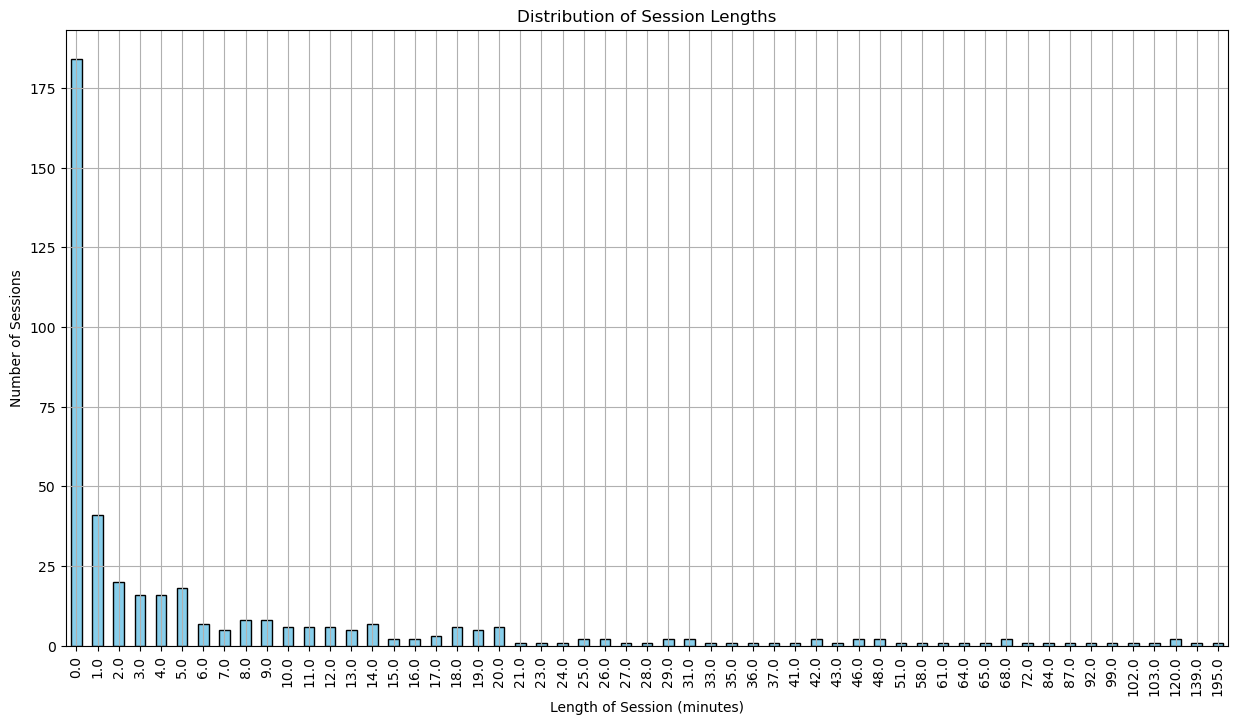

In [325]:
length_count = sessions['length_minutes'].value_counts().sort_index()

# Plotting the distribution of session lengths
plt.figure(figsize=(15, 8))
length_count.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Length of Session (minutes)')
plt.ylabel('Number of Sessions')
plt.title('Distribution of Session Lengths')
plt.grid(True)
plt.show()

In [326]:
# some stats
# nb of countries
countries_count = final_df['Country'].value_counts()
countries_count = countries_count.drop('null')
print("There are", len(countries_count), "different countries represented")
# nb of cities
cities_count = final_df['City'].value_counts()
cities_count = cities_count.drop('null')
print("There are", len(cities_count), "different cities represented")

There are 54 different countries represented
There are 350 different cities represented


In [327]:
# period 
lines_df.iloc[0]['Full_request']


'- - [31/Jan/2016:18:59:19 +0100] "GET /ark:/12148/bpt6k70211m HTTP/1.0" 200 24552 "-" "-" 48652'

In [328]:
lines_df.iloc[-1]['Full_request']

'- - [01/Feb/2016:05:29:53 +0100] "GET //iiif/ark:/12148/bpt6k6578404v/f460/full/2376,3885/0/native.jpg HTTP/1.1" 200 1028544 "-" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/45.0.2454.101 Safari/537.36" 2812213'

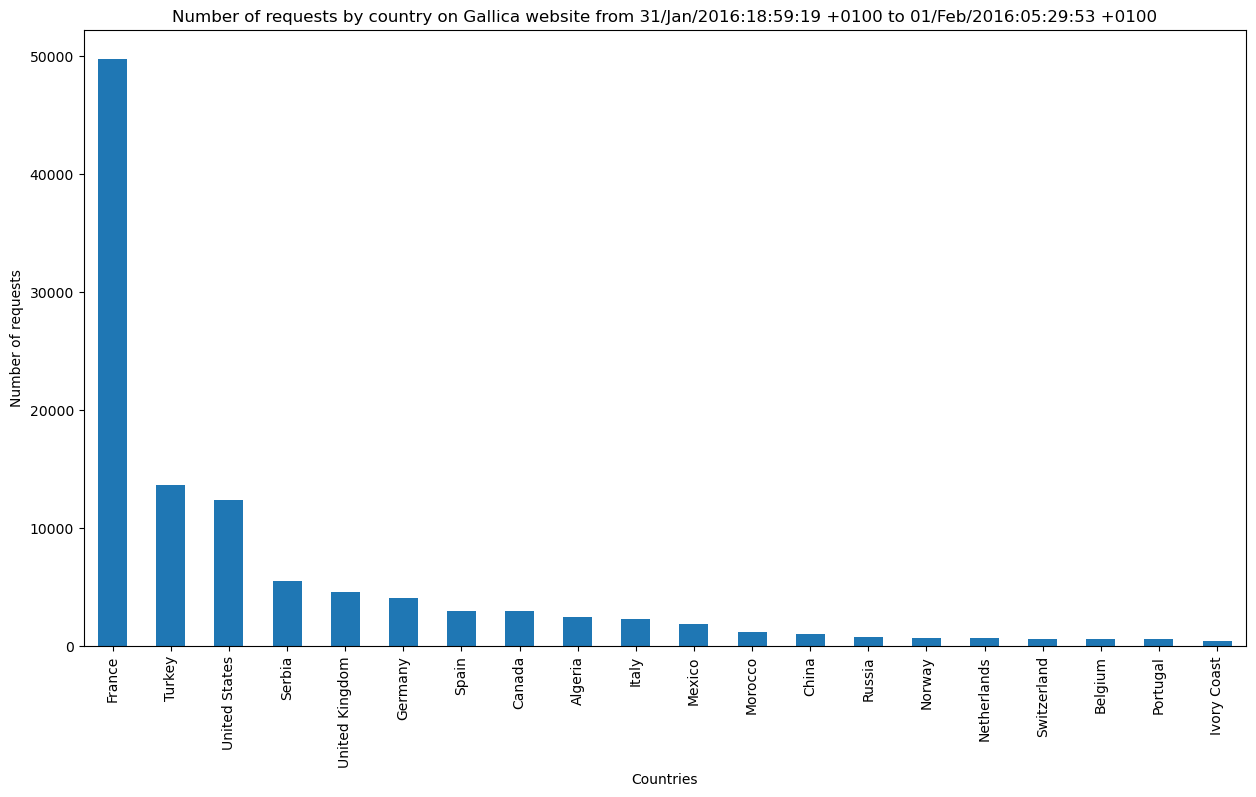

In [329]:
countries_count[:20].plot(kind='bar',figsize = (15,8));
plt.xlabel('Countries')
plt.ylabel('Number of requests')
plt.title('Number of requests by country on Gallica website from 31/Jan/2016:18:59:19 +0100 to 01/Feb/2016:05:29:53 +0100');


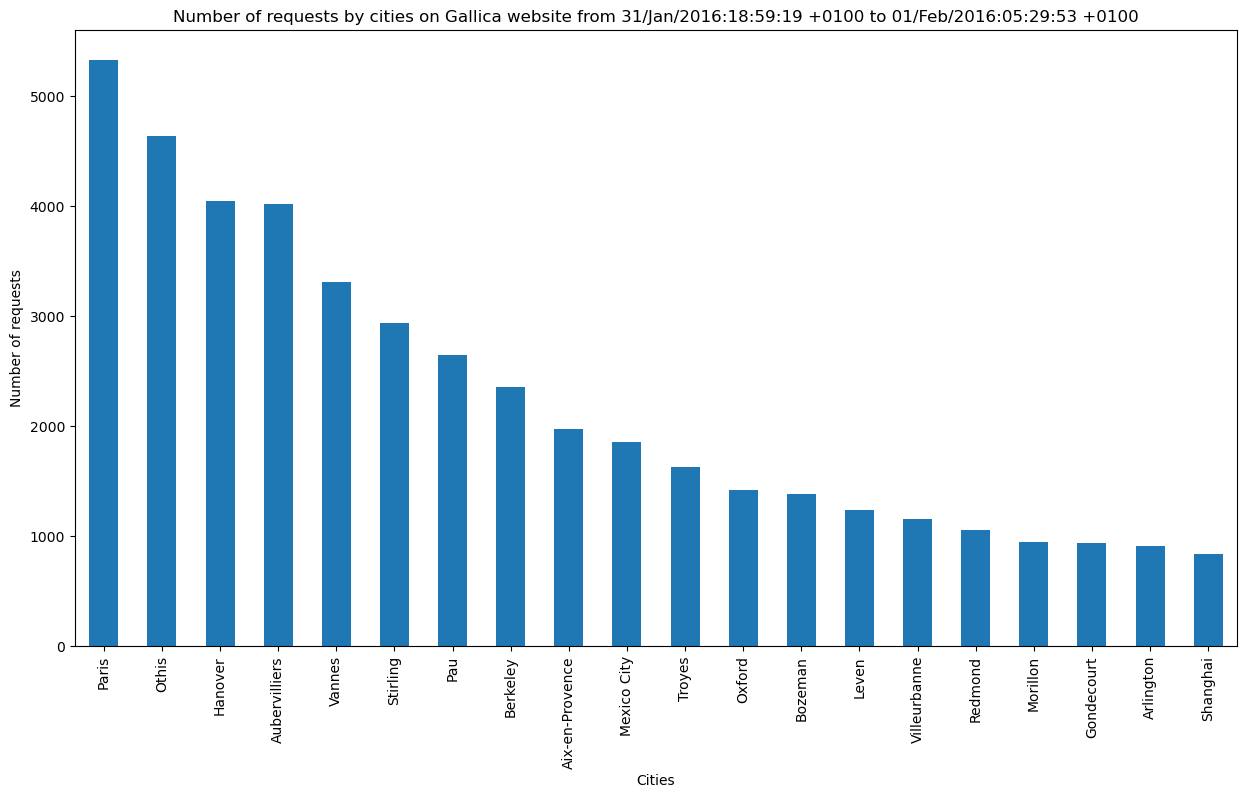

In [330]:
cities_count[:20].plot(kind='bar',figsize = (15,8));
plt.xlabel('Cities')
plt.ylabel('Number of requests')
plt.title('Number of requests by cities on Gallica website from 31/Jan/2016:18:59:19 +0100 to 01/Feb/2016:05:29:53 +0100');
